Transfer Learning with MobileNetV3

<a name='1'></a>
# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import tensorflow_datasets as tfds
import keras.layers as tfl
import tensorflow_addons as tfa
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from keras_flops import get_flops

from train_utils.callbacks import LossHistory, LRCallBack
from train_utils.models import PercentageModel

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Datasets

In [2]:
BATCH_SIZE = 32
PREFETCH = 2
IMG_SIZE = (384, 288)
OUTPUT_SIZE = (12, 9)
IMG_SHAPE = IMG_SIZE + (3,)
NUM_CLASSES = 133

In [3]:
train_dataset, train_info = tfds.load(
    'coco/2017_panoptic',
    split='train',
    batch_size=BATCH_SIZE,
    data_dir=r'C:\tensorflow_datasets',
    download=True,
    shuffle_files=True,
    with_info=True,
)

cv_dataset, cv_info = tfds.load(
    'coco/2017_panoptic',
    split='validation',
    batch_size=BATCH_SIZE,
    data_dir=r'C:\tensorflow_datasets',
    download=True,
    shuffle_files=True,
    with_info=True,
)

BATCHES = tf.data.experimental.cardinality(train_dataset).numpy()
print(BATCHES)

3697


# Preprocess Data

In [4]:
def preprocess_img(img, flip=False):
    processor = tf.keras.Sequential([
        tfl.Resizing(IMG_SHAPE[0], IMG_SHAPE[1]),
        tfl.RandomContrast(0.25),
        tfl.RandomBrightness(0.25),])
    if flip:
        tf.reverse(img, axis=0)
    return processor(img)

def preprocess_objects(objects, flip=False):
    batch_size = imgs.shape[0]
    y = np.zeros([batch_size, *OUTPUT_SIZE, 5 + NUM_CLASSES])
    imgs = imgs.numpy()
    batched_bboxs, batched_labels = objects['bbox'].numpy(), objects['label'].numpy()
    for i in range(batch_size):
        size, bboxs, labels, = imgs[i].shape, batched_bboxs[i], batched_labels[i]
        sw, sh = (1, size[0]/size[1]) if (size[0] > size[1]) else (size[1]/size[0], 1)
        for bbox, label in zip(bboxs, labels):
            ch, cw, _, _ = bbox
            if ch * sh < 1 and cw * sw < 1:
                y[i, label] = 1
    return y
    
def wrapper(func, inp, Tout, name=None):
    def wrapped_func(*flat_inp):
        reconstructed_inp = tf.nest.pack_sequence_as(inp, flat_inp, expand_composites=True)
        out = func(*reconstructed_inp)
        return out
    flat_out = tf.py_function(
        func=wrapped_func, 
        inp=tf.nest.flatten(inp, expand_composites=True),
        Tout=Tout,
        name=name)
    return flat_out

def preprocess(imgs, objects):
    horizontal_flip = np.random.ranf([1])[0] > 0.5
    inp = preprocess_img(imgs, horizontal_flip)
    out = preprocess_objects(objects, horizontal_flip)
    return inp, out

train_dataset = train_dataset.map(
                        lambda x: wrapper(
                            preprocess, 
                            [x['image'], x['panoptic_objects']], 
                            (tf.float32, tf.float32)), 
                        num_parallel_calls=PREFETCH).shuffle(
                            32, reshuffle_each_iteration=True
                        ).prefetch(buffer_size=PREFETCH)
cv_dataset = cv_dataset.map(
                        lambda x: wrapper(
                            preprocess, 
                            [x['image'], x['panoptic_objects']], 
                            (tf.float32, tf.float32)), 
                        num_parallel_calls=PREFETCH,)

# Hyper-Parameters

In [5]:
## 0 to skip
GRADIENT_CLIP = 1e2    # [5, 100]
FIXED_LAYERS = 0       # [0, 276]
LR = (-3,-5)          # [-3, -6]
EPOCHS = 5            # [0, 30]
BETA = 0.555             # (0, 1)   
GAMMA = 4.0              # [0, 6]
L2 = 1e-4                 # [-3, -6]
DROPOUT = 0.3

In [6]:
def mobilenet_model():
    model = tf.keras.applications.MobileNetV3Large(
        input_shape=IMG_SHAPE,
        include_top=False,
        dropout_rate=DROPOUT,
        pooling='avg',)
    model.trainable = True
    for layer in model.layers[:FIXED_LAYERS]:
        layer.trainable = False
    return model


def top_model(input_shape):
    inputs = tf.keras.Input(
        name='Input',
        shape=input_shape,)
    x = inputs
    
    x = tfl.Dense(
        units=NUM_CLASSES,
        name='Dense_0',
        kernel_regularizer=keras.regularizers.L2(L2),
        activation='sigmoid',)(x)
    
    outputs = x
    model = tf.keras.Model(
        inputs,
        outputs,
        name='Top')
    
    return model


def train_models():
    mobilenet = mobilenet_model()
    inputs = tf.keras.Input(
        name='Input',
        shape=IMG_SHAPE)
    top = top_model(
        input_shape=mobilenet.layers[-1].output_shape[1:])
    
    x = inputs
    x = mobilenet(x)
    x = top(x)
    
    outputs = x
    model = PercentageModel(
                inputs,
                outputs,
                name='full',)
    return {
        'mobilenet': mobilenet,
        'top': top,
        'train': model,}

## Estimate optimal learning rate

# Define Metrics

In [7]:
optimizer = tf.keras.optimizers.Adam(global_clipnorm=GRADIENT_CLIP)

metrics = [
    tfa.metrics.FBetaScore(
        num_classes=NUM_CLASSES,
        average='weighted',
        beta=0.1,
        threshold=BETA,
        name='F0.1',),
    tf.keras.metrics.Precision(
        thresholds=BETA,
        name='pre',),
    tf.keras.metrics.Recall(
        thresholds=BETA,
        name='rec',),]

models = train_models()
model = models['train']
model.compile(
    loss=tf.keras.losses.BinaryFocalCrossentropy(
        gamma=GAMMA,
        label_smoothing=1e-5),
    optimizer=optimizer,
    metrics=metrics,
    run_eagerly=True,
)
print(model.summary())

# print('Total Flops:', get_flops(model, batch_size=BATCH_SIZE) // 2)

Model: "full"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 MobilenetV3large (Functiona  (None, 960)              2996352   
 l)                                                              
                                                                 
 Top (Functional)            (None, 133)               127813    
                                                                 
Total params: 3,124,165
Trainable params: 3,099,765
Non-trainable params: 24,400
_________________________________________________________________
None


# Train

In [8]:
tqdm_callback = tfa.callbacks.TQDMProgressBar(
    metrics_separator=' | ',
    epoch_bar_format='{n_fmt}/{total_fmt} | ETA: {remaining} | Elapsed: {elapsed} {bar} {desc}',
    metrics_format='{name}: {value:0.2f}%',
    update_per_second=1,)

lr_callback = LRCallBack(epochs=EPOCHS, batches=BATCHES, l_r=LR)

history = model.fit(
    train_dataset,
    validation_data=cv_dataset,
    epochs=lr_callback.epochs,
    verbose=0,
    initial_epoch=0,
    callbacks=[tqdm_callback, lr_callback],)

Training:   0%|                                              0/5 ETA: ?s,  ?epochs/s

Epoch 1/5


0/3697 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.001000
Epoch 2/5


0/3697 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.000316
Epoch 3/5


0/3697 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.000100
Epoch 4/5


0/3697 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.000032
Epoch 5/5


0/3697 | ETA: ? | Elapsed: 00:00                                                    

LR set to: 0.000010


## Extended Training

# Plot the training and validation accuracy:

[0.00000000e+00 1.00005635e+00 2.00011271e+00 ... 1.77439999e+04
 1.77449999e+04 1.77460000e+04]


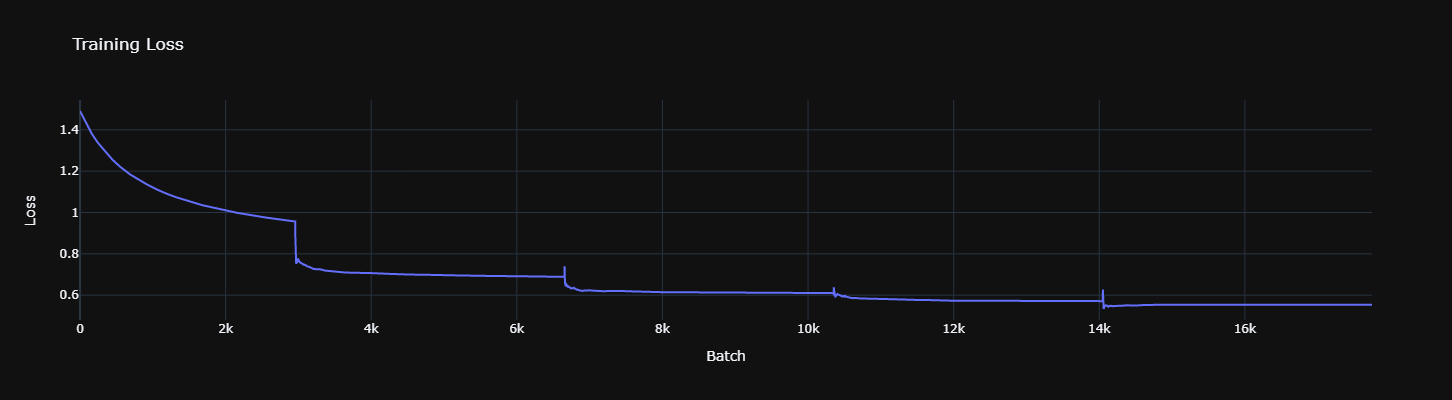

In [9]:
y = lr_callback.batch_losses[int(BATCHES*0.2):]
x = np.linspace(0, len(y), len(y))
print(x)
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=x,
        y=y,
        mode='lines',
        name='Loss',
    )
)
fig.update_layout(
    template='plotly_dark', 
    height=400, width=1500, 
    title_text='Training Loss',
    xaxis_title='Batch',
    yaxis_title='Loss',
)
fig.show()

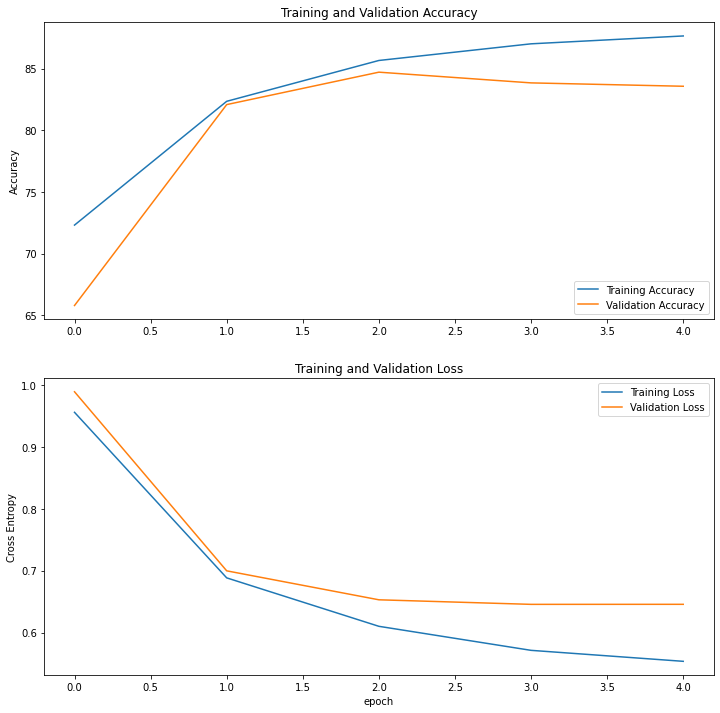

In [10]:
acc = history.history['F0.1']
val_acc = history.history['val_F0.1']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
#plt.ylim([0,100])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
#plt.ylim([0,100])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Compute Threshold

In [11]:
res = 11
x = np.linspace(0.55, 0.57, res, endpoint=True)
yf = np.zeros(res)
yr = np.zeros(res)
yp = np.zeros(res)

tqdm_callback = tfa.callbacks.TQDMProgressBar(
    metrics_separator=' | ',
    epoch_bar_format='{n_fmt}/{total_fmt} | ETA: {remaining} | Elapsed: {elapsed} {bar} {desc}',
    metrics_format='{name}: {value:0.2f}%',
    update_per_second=1,)

for i in range(res):
    beta = x[i]
    print(f'threshold = {beta}')
    metrics = [
        tfa.metrics.FBetaScore(
            num_classes=NUM_CLASSES,
            average='weighted',
            beta=0.1,
            threshold=beta,
            name='Fbeta',),
        tf.keras.metrics.Precision(
            thresholds=beta,
            name='pre',),
        tf.keras.metrics.Recall(
            thresholds=beta,
            name='rec',),]
    model.compile(
        loss=tf.keras.losses.BinaryFocalCrossentropy(
            gamma=GAMMA,
            label_smoothing=1e-5),
        metrics=metrics,
        run_eagerly=True,
    )
    result = model.evaluate(
        cv_dataset, 
        verbose=0, 
        return_dict=True,
        callbacks=[tqdm_callback],)
    yf[i] = result['Fbeta']
    yr[i] = result['rec']
    yp[i] = result['pre']

threshold = 0.55


0/157 | ETA: ? | Elapsed: 00:00                                           Evaluating

threshold = 0.552


0/157 | ETA: ? | Elapsed: 00:00                                           Evaluating

threshold = 0.554


0/157 | ETA: ? | Elapsed: 00:00                                           Evaluating

threshold = 0.556


0/157 | ETA: ? | Elapsed: 00:00                                           Evaluating

threshold = 0.558


0/157 | ETA: ? | Elapsed: 00:00                                           Evaluating

threshold = 0.56


0/157 | ETA: ? | Elapsed: 00:00                                           Evaluating

threshold = 0.5619999999999999


0/157 | ETA: ? | Elapsed: 00:00                                           Evaluating

threshold = 0.564


0/157 | ETA: ? | Elapsed: 00:00                                           Evaluating

threshold = 0.566


0/157 | ETA: ? | Elapsed: 00:00                                           Evaluating

threshold = 0.568


0/157 | ETA: ? | Elapsed: 00:00                                           Evaluating

threshold = 0.57


0/157 | ETA: ? | Elapsed: 00:00                                           Evaluating

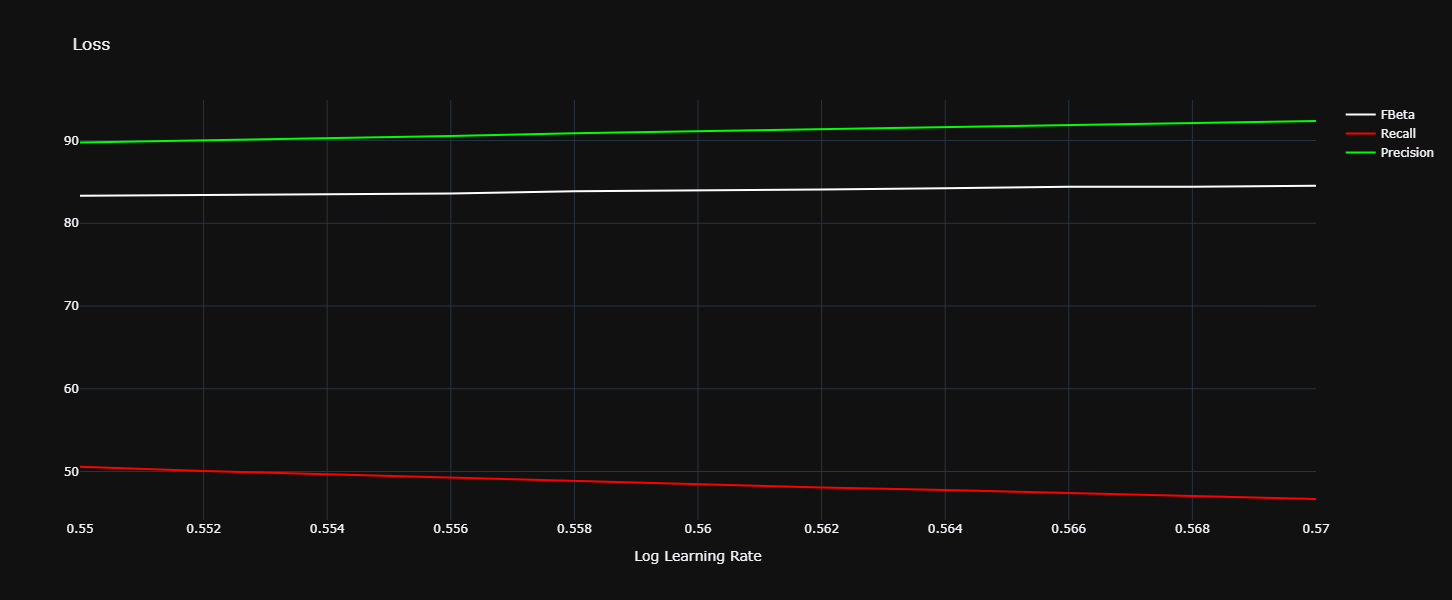

In [12]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=x, 
        y=yf,
        mode='lines',
        name='FBeta',
        line_color="#fff"
    )
)
fig.add_trace(
    go.Scatter(
        x=x, 
        y=yr,
        mode='lines',
        name='Recall',
        line_color="#f00"
    )
)
fig.add_trace(
    go.Scatter(
        x=x, 
        y=yp,
        mode='lines',
        name='Precision',
        line_color="#0f0"
    )
)
fig.update_layout(
    template='plotly_dark', 
    height=600, width=1000, 
    title_text='Loss',
    xaxis_title='Log Learning Rate',
    yaxis_title='',
)
fig.show()

# Save the model

In [13]:
for name, model in models.items():
    model.save(f'models\\objects\\{name}.h5')
    model.save_weights(f'models\\objects\\{name}_weights.h5')